# Set Up

## Import packages and data

In [1]:
# Load Tensorflow
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from __future__ import absolute_import, division, print_function, \
unicode_literals

import tensorflow as tf
import tensorflow_hub as hub
import os

import io
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, \
StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv1D, \
MaxPooling2D, Dropout, Flatten, Reshape, Embedding
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer, \
text_to_word_sequence, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import word_tokenize
import nltk
import re
import pickle
import zipfile
import time

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#  !pip install bert_embedding
#  from bert_embedding import BertEmbedding

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
#Check Version
tf.__version__

'1.15.2'

In [4]:
# Using Google Colab, upload data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## EDA


In [0]:
# Load training and test data
train_data = pd.read_csv("/content/drive/My Drive/disasters/train.csv")
test_data = pd.read_csv("/content/drive/My Drive/disasters/test.csv")

In [0]:
train_text_orig = train_data['text'].values.tolist()
train_target = train_data['target'].values.tolist()

# filling in NAs with 'unknown' for keywords that are blank
train_data['keyword'].fillna('unknown', inplace = True)
keyword_orig = train_data['keyword'].values.tolist()

(array([  85.,  296.,  445.,  551.,  779.,  973.,  961., 1032., 2334.,
         157.]),
 array([  7.,  22.,  37.,  52.,  67.,  82.,  97., 112., 127., 142., 157.]),
 <a list of 10 Patch objects>)

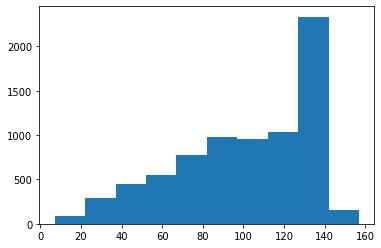

In [0]:
# Tweet length distribution
lens = [len(x) for x in train_text_orig]
plt.hist(lens,10)

In [0]:
# Class distribution
train_data['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [0]:
# Check for null values
train_data.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [0]:
# Example Tweet
train_data['text'][7034]

'(#LosDelSonido) Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Ma...  (#IvanBerroa)'

## Preprocessing


In [0]:
# Preprocess data
def preprocess_basic(s):
    # All letters to lowercase
    s = s.lower()
    s = re.sub('%20',' ', s)

    # Only keep words and spaces
    s = re.sub('[^\w\s]','', s)
    
    # Replace all numbers with 'N'
    s = re.sub('\d+','N', s)
    
    # Delete extra spaces
    s = re.sub('[\s]+',' ', s)
    
    return s

def preprocess_portstem(s):
    # All letters to lowercase
    s = s.lower()
    s = re.sub('%20',' ', s)

    # Only keep words and spaces
    s = re.sub('[^\w\s]','', s)
    
    # Replace all numbers with 'N'
    s = re.sub('\d+','N', s)
    
    # Delete extra spaces
    s = re.sub('[\s]+',' ', s)

    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    s = nltk.tokenize.word_tokenize(s)
    s = [word for word in s if not word in stop_words]
    
    # Stem to remove common word endings from each word
    stemmer = nltk.stem.PorterStemmer()
    s = [stemmer.stem(word) for word in s]
    
    # Do not need to lemmatize https://arxiv.org/abs/1909.03135
    # Lemmatize to get the correct base forms of words
    lemmatizer = nltk.stem.WordNetLemmatizer()
    s = [lemmatizer.lemmatize(word) for word in s]
    
    # Convert back to string
    s = ' '.join(s)

    return s

def preprocess_smart(s):
    # All letters to lowercase
    s = s.lower()
    # s = re.sub('%20',' ', s)

    # Remove @s
    s = re.sub(r'\@\S+',' ',s)

    # Remove URLs
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    
    # Remove HTML
    s = re.sub(r'<.*?>', ' ', s)

    # Only keep words and spaces
    s = re.sub('[^\w\s]','', s)
    
    # Replace all numbers with 'N'
    s = re.sub('\d+','N', s)
    
    # Delete extra spaces
    s = re.sub('[\s]+',' ', s)

    return s

In [0]:
# Making sure preprocessing works

example=np.array(['Get rid of this link: https://www.google.com/c/what_is_nlp','What now @letsgobabay 😔😔','<div> <h1>Title</h1> <p>Happy </p> <a href="https://www.kaggle.com/c/nlp-getting-started"> lets go </a> </div>'])
exampledf = pd.DataFrame(example, columns=['text']) 
clean_eg = exampledf['text'].apply(lambda x: preprocess_smart(x)).tolist()
print(clean_eg)

['get rid of this link ', 'what now ', ' title happy ']


In [0]:
# Applying basic preprocessing of text
train_text_basic = train_data['text'].apply(lambda x: preprocess_basic(x)).tolist()
keyword_basic = train_data['text'].apply(lambda x: preprocess_basic(x)).tolist()

# Applying stemmed and lemmatized preprocessing of text
train_text_portstem = train_data['text'].apply(lambda x: preprocess_portstem(x)).tolist()

# Applying smart preprocessing of text
train_text_smart = train_data['text'].apply(lambda x: preprocess_smart(x)).tolist()

In [0]:
def explore_Preprop(x):  #where x is the index in train_text
    print('Original - ', train_text_orig[x])
    print('Basic - ', train_text_basic[x])
    print('PortStem - ', train_text_portstem[x])
    print('Smart - ', train_text_smart[x])

# for i in range(15):
#     explore_Preprop(i)

explore_Preprop(65)

Original -  @nxwestmidlands huge fire at Wholesale markets ablaze http://t.co/rwzbFVNXER
Basic -  nxwestmidlands huge fire at wholesale markets ablaze httptcorwzbfvnxer
PortStem -  nxwestmidland huge fire wholesal market ablaz httptcorwzbfvnxer
Smart -   huge fire at wholesale markets ablaze 


In [0]:
# pickle_out = open("/content/drive/My Drive/disasters/train_text_orig.pickle","wb")
# pickle.dump(train_text_orig, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/train_text_basic.pickle","wb")
# pickle.dump(train_text_basic, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/train_text_portstem.pickle","wb")
# pickle.dump(train_text_portstem, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/train_text_smart.pickle","wb")
# pickle.dump(train_text_smart, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/keyword_orig.pickle","wb")
# pickle.dump(keyword_orig, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/keyword_basic.pickle","wb")
# pickle.dump(keyword_basic, pickle_out)
# pickle_out.close()

# Generating Embeddings

## Self trained embeddings

In [0]:
def selfembed(train_list):
    all_words = []
    for sent in train_list:
        tokenize_word = word_tokenize(sent)
        for word in tokenize_word:
            all_words.append(word)
    unique_words = set(all_words)
    vocab_length = len(unique_words)+1
    print ('There are {} unique words in the corpus'.format(str(vocab_length)))
    embedded_sentences = [one_hot(sent, vocab_length) for sent in train_list]
    word_count = lambda sentence: len(word_tokenize(sentence))
    longest_sentence = max(train_list, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    print ('The longest sentence contains {} words'.
           format(str(length_long_sentence)))
    padded_sentences = pad_sequences(embedded_sentences,
                                     length_long_sentence, padding='post')
    return padded_sentences, vocab_length, length_long_sentence

In [22]:
padded_sentences_orig_self, vocab_length_orig_self, length_long_sentence_orig_self = selfembed(train_text_orig)
padded_sentences_basic_self, vocab_length_basic_self, length_long_sentence_basic_self = selfembed(train_text_basic)
padded_sentences_portstem_self, vocab_length_portstem_self, length_long_sentence_portstem_self = selfembed(train_text_portstem)
padded_sentences_smart_self, vocab_length_smart_self, length_long_sentence_smart_self = selfembed(train_text_smart)

There are 27292 unique words in the corpus
The longest sentence contains 72 words
There are 22042 unique words in the corpus
The longest sentence contains 31 words
There are 18852 unique words in the corpus
The longest sentence contains 25 words
There are 15230 unique words in the corpus
The longest sentence contains 31 words


## Using GLOVE embedding 

In [0]:
def getGloveDict():
    embeddings_dictionary = dict()
    glove_file = open('/content/drive/My Drive/glove.twitter.27B.100d.txt',
                      encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

    glove_file.close()

    return embeddings_dictionary

gloveDict = getGloveDict()

In [0]:
def gloveEmbed(train_list):
    word_tokenizer = Tokenizer()
    word_tokenizer.fit_on_texts(train_list)
    vocab_length = len(word_tokenizer.word_index) + 1
    print ('There are {} unique words in the corpus'.format(str(vocab_length)))
    embedded_sentences = word_tokenizer.texts_to_sequences(train_list)
    word_count = lambda sentence: len(word_tokenize(sentence))
    longest_sentence = max(train_list, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    print ('The longest sentence contains {} words'.
           format(str(length_long_sentence)))
    padded_sentences = pad_sequences(embedded_sentences,
                                     length_long_sentence, padding='post')
    return word_tokenizer, padded_sentences, vocab_length, length_long_sentence

In [0]:
def getEmbedMatrix(word_tokenizer, vocab_length,
                   embeddings_dictionary = gloveDict, embed_dim = 100):
    
    embedding_matrix = np.zeros((vocab_length, embed_dim))
    for word, index in word_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [12]:
word_tokenizer_orig_glv, padded_sentences_orig_glv, vocab_length_orig_glv, \
length_long_sentence_orig_glv = gloveEmbed(train_text_orig)
embedMat_orig_glv = getEmbedMatrix(word_tokenizer_orig_glv,
                                   vocab_length_orig_glv)

word_tokenizer_basic_glv, padded_sentences_basic_glv, vocab_length_basic_glv, \
length_long_sentence_basic_glv = gloveEmbed(train_text_basic)
embedMat_basic_glv = getEmbedMatrix(word_tokenizer_basic_glv,
                                    vocab_length_basic_glv)

word_tokenizer_portstem_glv, padded_sentences_portstem_glv, \
vocab_length_portstem_glv, length_long_sentence_portstem_glv = \
gloveEmbed(train_text_portstem)
embedMat_portstem_glv = getEmbedMatrix(word_tokenizer_portstem_glv,
                                       vocab_length_portstem_glv)

word_tokenizer_smart_glv, padded_sentences_smart_glv, vocab_length_smart_glv, \
length_long_sentence_smart_glv = gloveEmbed(train_text_smart)
embedMat_smart_glv = getEmbedMatrix(word_tokenizer_smart_glv,
                                    vocab_length_smart_glv)

There are 22701 unique words in the corpus
The longest sentence contains 72 words
There are 22018 unique words in the corpus
The longest sentence contains 31 words
There are 18871 unique words in the corpus
The longest sentence contains 25 words
There are 15186 unique words in the corpus
The longest sentence contains 31 words


## ELMO

In [0]:
list_train_orig = [train_text_orig[i:i+100] for i in 
                   range(0,len(train_text_orig),100)]
list_train_basic = [train_text_basic[i:i+100] for i in 
                    range(0,len(train_text_basic),100)]
list_train_portstem = [train_text_portstem[i:i+100] for i in 
                       range(0,len(train_text_portstem),100)]
list_train_smart = [train_text_smart[i:i+100] for i in 
                    range(0,len(train_text_smart),100)]

In [0]:
def getElmoVectors(x):
    start = time.time()
    module = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
    tensor_in = tf.placeholder(tf.string, shape=[None])  # As befits `module`.
    tensor_out = module(tensor_in)
    elmo_out = []
    # This kind of session handles init ops for you.
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        for pystr in x:
            batch_in = np.array(pystr)            
            batch_out = sess.run(tensor_out, feed_dict={tensor_in: batch_in})
            elmo_out.append(batch_out)
    print("Run time: {} seconds".format(time.time() - start))
    return np.concatenate(elmo_out, axis = 0)

In [0]:
embeddings_orig_elmo = getElmoVectors(list_train_orig)
embeddings_basic_elmo = getElmoVectors(list_train_basic)
embeddings_portstem_elmo = getElmoVectors(list_train_portstem)
embeddings_smart_elmo = getElmoVectors(list_train_smart)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 34.097904920578 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 21.130938053131104 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 16.82296323776245 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 22.150415658950806 seconds


In [0]:
# pickle_out = open("/content/drive/My Drive/disasters/embeddings_orig_elmo.pickle","wb")
# pickle.dump(embeddings_orig_elmo, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_basic_elmo.pickle","wb")
# pickle.dump(embeddings_basic_elmo, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_portstem_elmo.pickle","wb")
# pickle.dump(embeddings_portstem_elmo, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_smart_elmo.pickle","wb")
# pickle.dump(embeddings_smart_elmo, pickle_out)
# pickle_out.close()

## USE Universal Sentence Encoder (DAN)

In [0]:
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

In [0]:
def getUSEDEmbeddings(train_list):
    start = time.time()
    with tf.Session() as session:
      session.run([tf.global_variables_initializer(), tf.tables_initializer()])
      message_embeddings = session.run(embed(train_list))
    print("Run time: {} seconds".format(time.time() - start))
    return message_embeddings

In [25]:
embeddings_orig_used = getUSEDEmbeddings(train_text_orig)
embeddings_basic_used = getUSEDEmbeddings(train_text_basic)
embeddings_portstem_used = getUSEDEmbeddings(train_text_portstem)
embeddings_smart_used = getUSEDEmbeddings(train_text_smart)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 13.871870040893555 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 12.506625890731812 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 12.700639963150024 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 13.894443988800049 seconds


In [0]:
# pickle_out = open("/content/drive/My Drive/disasters/embeddings_orig_used.pickle","wb")
# pickle.dump(embeddings_orig_used, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_basic_used.pickle","wb")
# pickle.dump(embeddings_basic_used, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_portstem_used.pickle","wb")
# pickle.dump(embeddings_portstem_used, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_smart_used.pickle","wb")
# pickle.dump(embeddings_smart_used, pickle_out)
# pickle_out.close()

## USE (Transformer)

In [0]:
embedT = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

In [0]:
def getUSETEmbeddings(train_list):
    start = time.time()
    with tf.Session() as session:
      session.run([tf.global_variables_initializer(), tf.tables_initializer()])
      message_embeddings = session.run(embedT(train_list))
    print("Run time: {} seconds".format(time.time() - start))
    return message_embeddings

In [15]:
embeddings_orig_uset = getUSETEmbeddings(train_text_orig)
embeddings_basic_uset = getUSETEmbeddings(train_text_basic)
embeddings_portstem_uset = getUSETEmbeddings(train_text_portstem)
embeddings_smart_uset = getUSETEmbeddings(train_text_smart)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 13.123965740203857 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 5.174824953079224 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 5.12683367729187 seconds
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Run time: 5.85853385925293 seconds


In [0]:
# pickle_out = open("/content/drive/My Drive/disasters/embeddings_orig_uset.pickle","wb")
# pickle.dump(embeddings_orig_uset, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_basic_uset.pickle","wb")
# pickle.dump(embeddings_basic_uset, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_portstem_uset.pickle","wb")
# pickle.dump(embeddings_portstem_uset, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_smart_uset.pickle","wb")
# pickle.dump(embeddings_smart_uset, pickle_out)
# pickle_out.close()

## BERT

In [0]:
# !pip install bert_embedding
# from bert_embedding import BertEmbedding

In [0]:
def getBertEmbeddings(train_list):
    start = time.time()
    bert_embedding = BertEmbedding()
    result = bert_embedding(train_list)  #result is before averaging 
    bert_embeddings = []
    for i in range(len(result)):
        new_embed = np.mean(result[i][1], axis = 0, dtype=np.float64)
        bert_embeddings.append(new_embed)
    print("Run time: {} seconds".format(time.time() - start))
    return bert_embeddings

In [0]:
# embeddings_orig_bert = getBertEmbeddings(train_text_orig)
# embeddings_basic_bert = getBertEmbeddings(train_basic_orig)
# embeddings_portstem_bert = getBertEmbeddings(train_portstem_orig)
# embeddings_smart_bert = getBertEmbeddings(train_smart_orig)

In [0]:
# pickle_out = open("/content/drive/My Drive/disasters/embeddings_orig_bert.pickle","wb")
# pickle.dump(embeddings_orig_bert, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_basic_bert.pickle","wb")
# pickle.dump(embeddings_basic_bert, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_portstem_bert.pickle","wb")
# pickle.dump(embeddings_portstem_bert, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/disasters/embeddings_smart_bert.pickle","wb")
# pickle.dump(embeddings_smart_bert, pickle_out)
# pickle_out.close()

# Model Building and Results

## Load pickled embeddings

In [0]:
pickle_in = open("/content/drive/My Drive/disasters/embeddings_orig_elmo.pickle", "rb")
embeddings_orig_elmo = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/disasters/embeddings_basic_elmo.pickle", "rb")
embeddings_basic_elmo = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/disasters/embeddings_portstem_elmo.pickle", "rb")
embeddings_portstem_elmo = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/disasters/embeddings_smart_elmo.pickle", "rb")
embeddings_smart_elmo = pickle.load(pickle_in)

In [0]:
pickle_in = open("/content/drive/My Drive/disasters/embeddings_orig_bert.pickle", "rb")
embeddings_orig_bert = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/disasters/embeddings_basic_bert.pickle", "rb")
embeddings_basic_bert = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/disasters/embeddings_portstem_bert.pickle", "rb")
embeddings_portstem_bert = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/disasters/embeddings_smart_bert.pickle", "rb")
embeddings_smart_bert = pickle.load(pickle_in)

## Model Building

In [0]:
# Need to convert bert embeddings lists into numpy arrays
def toArr(list1,list2): 
    list1 = np.array(list1)
    list2 = np.array(list2)
    return list1,list2

In [0]:
xtrain_orig_self, xvalid_orig_self, \
xtrain_orig_glv, xvalid_orig_glv, \
xtrain_orig_used, xvalid_orig_used, \
xtrain_orig_uset, xvalid_orig_uset, \
xtrain_orig_bert, xvalid_orig_bert, \
xtrain_orig_elmo, xvalid_orig_elmo, \
ytrain_orig, yvalid_orig = \
train_test_split(padded_sentences_orig_self, padded_sentences_orig_glv,
                 embeddings_orig_used, embeddings_orig_uset, 
                 embeddings_orig_bert, embeddings_orig_elmo, 
                 train_target, random_state=42,
                 test_size=0.2)

xtrain_basic_self, xvalid_basic_self, \
xtrain_basic_glv, xvalid_basic_glv, \
xtrain_basic_used, xvalid_basic_used, \
xtrain_basic_uset, xvalid_basic_uset, \
xtrain_basic_bert, xvalid_basic_bert, \
xtrain_basic_elmo, xvalid_basic_elmo, \
ytrain_basic, yvalid_basic = \
train_test_split(padded_sentences_basic_self, padded_sentences_basic_glv,
                 embeddings_basic_used, embeddings_basic_uset,
                 embeddings_basic_bert, embeddings_basic_elmo,
                 train_target, random_state=42,
                 test_size=0.2)


xtrain_portstem_self, xvalid_portstem_self, \
xtrain_portstem_glv, xvalid_portstem_glv, \
xtrain_portstem_used, xvalid_portstem_used, \
xtrain_portstem_uset, xvalid_portstem_uset, \
xtrain_portstem_bert, xvalid_portstem_bert, \
xtrain_portstem_elmo, xvalid_portstem_elmo, \
ytrain_portstem, yvalid_portstem = \
train_test_split(padded_sentences_portstem_self, padded_sentences_portstem_glv,
                 embeddings_portstem_used, embeddings_portstem_uset, 
                 embeddings_portstem_bert, embeddings_portstem_elmo, 
                 train_target, random_state=42,
                 test_size=0.2)

xtrain_smart_self, xvalid_smart_self, \
xtrain_smart_glv, xvalid_smart_glv, \
xtrain_smart_used, xvalid_smart_used, \
xtrain_smart_uset, xvalid_smart_uset, \
xtrain_smart_bert, xvalid_smart_bert, \
xtrain_smart_elmo, xvalid_smart_elmo, \
ytrain_smart, yvalid_smart = \
train_test_split(padded_sentences_smart_self, padded_sentences_smart_glv,
                 embeddings_smart_used, embeddings_smart_uset, 
                 embeddings_smart_bert, embeddings_smart_elmo,
                 train_target, random_state=42,
                 test_size=0.2)

In [0]:
xtrain_orig_bert, xvalid_orig_bert = toArr(xtrain_orig_bert,
                                           xvalid_orig_bert)
xtrain_basic_bert, xvalid_basic_bert = toArr(xtrain_basic_bert,
                                             xvalid_basic_bert)
xtrain_portstem_bert, xvalid_portstem_bert = toArr(xtrain_portstem_bert,
                                                   xvalid_portstem_bert)
xtrain_smart_bert, xvalid_smart_bert = toArr(xtrain_smart_bert,
                                             xvalid_smart_bert)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression(max_iter=1000)
lreg.fit(xtrain_orig_elmo, ytrain_orig)

preds_valid = lreg.predict(xvalid_orig_elmo)
f1 = f1_score(yvalid_orig, preds_valid)
acc = sum(preds_valid == yvalid_orig)/len(yvalid_orig)
print(f1, acc)

0.7414634146341463 0.7912015758371634


In [0]:
def train_input_fn(x_train, y_train, bs):
    # Convert the inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    
    # Shuffle, repeat, and batch the examples
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(bs, drop_remainder=True)
    dataset = dataset.prefetch(-1)

    # Return the dataset
    return dataset

def val_input_fn(x_val, y_val):
    # Convert the inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    
    # Shuffle, repeat, and batch the examples
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(len(y_val), drop_remainder=True)
    # Return the dataset.
    return dataset

In [0]:
def get_model_dense(shp):
    inp = tf.keras.Input(shape=(shp,), dtype=tf.float32)
    x = tf.keras.layers.Dense(16, activation='relu')(inp)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [0]:
def get_model_embed(shp, vcb_sz, dim, wt):
    inp = tf.keras.Input(shape=(shp,), dtype=tf.float32)
    if wt == 'None':
        x = tf.keras.layers.Embedding(vcb_sz, dim,
                            input_length=shp,
                            trainable=False)(inp)
    else:
        x = tf.keras.layers.Embedding(vcb_sz, dim, weights=[wt],
                            input_length=shp,
                            trainable=False)(inp)
    # x = tf.keras.layers.Conv1D(filters=4, kernel_size=2,
    #                             activation='relu', strides=2)(x)
    # x = tf.keras.layers.GlobalMaxPool1D()(x)
    #x = tf.keras.layers.Dense(8, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [0]:
def model_run(bs, ep, lr, typ, xt, yt, xv, yv, embd=None):
    
    tf.keras.backend.clear_session()
    if typ == 'dense':
        shp = len(xt[0])
        model = get_model_dense(shp)
    elif typ == 'embed':
        shp = embd[0]
        vcb_sz = embd[1]
        dim = embd[2]
        wt = embd[3]
        model = get_model_embed(shp, vcb_sz, dim, wt)
    elif typ == 'bertkw':
        shp1 = len(xt[0][0])
        shp2 = embd[0]
        vcb_sz2 = embd[1]
        dim2 = embd[2]
        wt2 = embd[3]
        model = get_model_bert_kwglv(shp1, shp2, vcb_sz2, dim2, wt2)
    elif typ == 'ubg':
        shp1 = len(xt[0][0])
        shp2 = len(xt[1][0])
        shp3 = embd[0]
        vcb_sz3 = embd[1]
        dim3 = embd[2]
        wt3 = embd[3]
        model = get_model_used_bert_glv(shp1, shp2, shp3, vcb_sz3, dim3, wt3)
    else:
        return None
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])
    model.summary()
    
    B_S = bs
    num_epochs = ep
    val_dim = len(yv)
    es = EarlyStopping(monitor='val_loss', patience=50)
    # mc = ModelCheckpoint('/content/drive/My Drive/model1.h5',
    #                      monitor='val_loss',
    #                      save_best_only=True,
    #                      mode='auto')
    fitted = model.fit(train_input_fn(xt, yt, bs),
                       epochs=num_epochs, verbose=1,
                       validation_data=val_input_fn(xv, yv),
                       validation_steps=1, callbacks=[es],
                       steps_per_epoch=-(val_dim//-(B_S)))
    
    preds = model.predict(xv) > .5
    preds = np.array([1 if x==True else 0 for [x] in preds])
    f1 = f1_score(yv, preds)
    acc = sum(preds == np.array(yv))/len(yv)

    plt.plot(fitted.history['loss'])
    plt.plot(fitted.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log')
    #plt.ylim(3e-1, 6e0)
    plt.legend(['train', 'validation'])
    plt.show()

    return f1, acc

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 72, 200)           5458400   
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 14401     
Total params: 5,472,801
Trainable params: 14,401
Non-trainable params: 5,458,400
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6840 - acc: 0.5755 - val_loss: 0.6795 - val_acc: 0.5739
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0

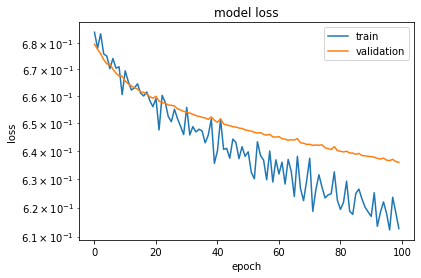

In [0]:
f1_orig_self, acc_orig_self = \
model_run(bs=32, ep=100, lr=.0001, typ='embed',
          xt=xtrain_orig_self, yt=ytrain_orig,
          xv=xvalid_orig_self, yv=yvalid_orig,
          embd = [length_long_sentence_orig_self,
                  vocab_length_orig_self,
                  200, 'None'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 31, 200)           4408400   
_________________________________________________________________
flatten (Flatten)            (None, 6200)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6201      
Total params: 4,414,601
Trainable params: 6,201
Non-trainable params: 4,408,400
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6899 - acc: 0.5202 - val_loss: 0.6843 - val_acc: 0.5699
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.

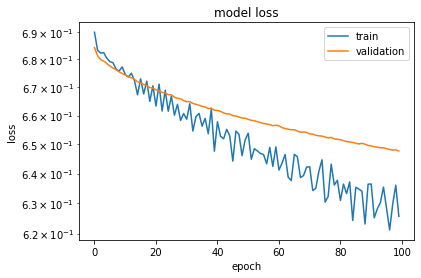

In [0]:
f1_basic_self, acc_basic_self = \
model_run(bs=32, ep=100, lr=.0001, typ='embed',
          xt=xtrain_basic_self, yt=ytrain_basic,
          xv=xvalid_basic_self, yv=yvalid_basic,
          embd = [length_long_sentence_basic_self,
                  vocab_length_basic_self,
                  200, 'None'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 200)           3770400   
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5001      
Total params: 3,775,401
Trainable params: 5,001
Non-trainable params: 3,770,400
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6875 - acc: 0.5547 - val_loss: 0.6801 - val_acc: 0.5758
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.

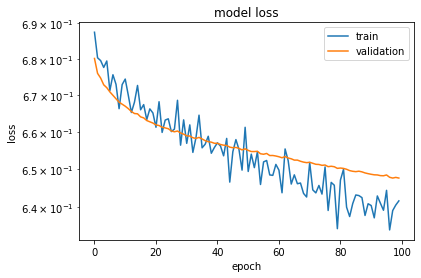

In [0]:
f1_portstem_self, acc_portstem_self = \
model_run(bs=32, ep=100, lr=.0001, typ='embed',
          xt=xtrain_portstem_self, yt=ytrain_portstem,
          xv=xvalid_portstem_self, yv=yvalid_portstem,
          embd = [length_long_sentence_portstem_self,
                  vocab_length_portstem_self,
                  200, 'None'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 31, 200)           3046000   
_________________________________________________________________
flatten (Flatten)            (None, 6200)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6201      
Total params: 3,052,201
Trainable params: 6,201
Non-trainable params: 3,046,000
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6898 - acc: 0.5534 - val_loss: 0.6832 - val_acc: 0.5706
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.

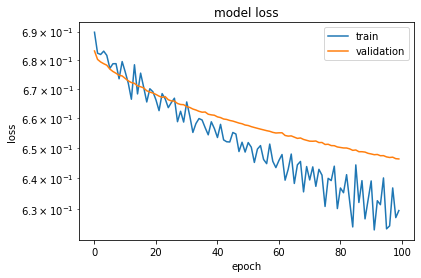

In [0]:
f1_smart_self, acc_smart_self = \
model_run(bs=32, ep=100, lr=.0001, typ='embed',
          xt=xtrain_smart_self, yt=ytrain_smart,
          xv=xvalid_smart_self, yv=yvalid_smart,
          embd = [length_long_sentence_smart_self,
                  vocab_length_smart_self,
                  200, 'None'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 72, 100)           2270100   
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7201      
Total params: 2,277,301
Trainable params: 7,201
Non-trainable params: 2,270,100
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6707 - acc: 0.5996 - val_loss: 0.6647 - val_acc: 0.5962
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.

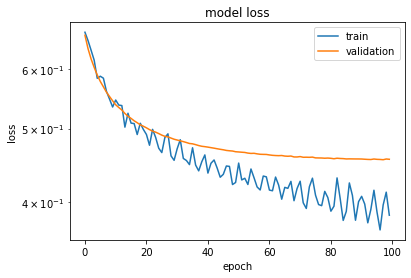

In [0]:
f1_orig_glv, acc_orig_glv = \
model_run(bs=32, ep=100, lr=.0001, typ='embed',
          xt=xtrain_orig_glv, yt=ytrain_orig,
          xv=xvalid_orig_glv, yv=yvalid_orig,
          embd=[length_long_sentence_orig_glv,
                vocab_length_orig_glv,
                100, embedMat_orig_glv])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 31, 100)           2201800   
_________________________________________________________________
flatten (Flatten)            (None, 3100)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3101      
Total params: 2,204,901
Trainable params: 3,101
Non-trainable params: 2,201,800
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6671 - acc: 0.5840 - val_loss: 0.6581 - val_acc: 0.6120
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.

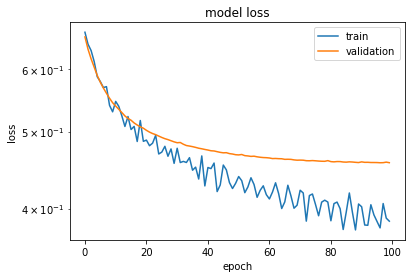

In [0]:
f1_basic_glv, acc_basic_glv = \
model_run(bs=32, ep=100, lr=.0001, typ='embed',
          xt=xtrain_basic_glv, yt=ytrain_basic,
          xv=xvalid_basic_glv, yv=yvalid_basic,
          embd=[length_long_sentence_basic_glv,
                vocab_length_basic_glv,
                100, embedMat_basic_glv])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 100)           1887100   
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2501      
Total params: 1,889,601
Trainable params: 2,501
Non-trainable params: 1,887,100
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.7046 - acc: 0.5247 - val_loss: 0.6873 - val_acc: 0.5404
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.

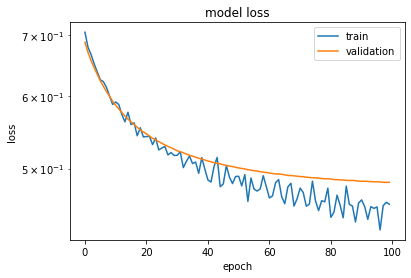

In [0]:
f1_portstem_glv, acc_portstem_glv = \
model_run(bs=32, ep=100, lr=.0001, typ='embed',
          xt=xtrain_portstem_glv, yt=ytrain_portstem,
          xv=xvalid_portstem_glv, yv=yvalid_portstem,
          embd=[length_long_sentence_portstem_glv,
                vocab_length_portstem_glv,
                100, embedMat_portstem_glv])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 31, 100)           1518600   
_________________________________________________________________
flatten (Flatten)            (None, 3100)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3101      
Total params: 1,521,701
Trainable params: 3,101
Non-trainable params: 1,518,600
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6865 - acc: 0.5638 - val_loss: 0.6734 - val_acc: 0.5739
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.

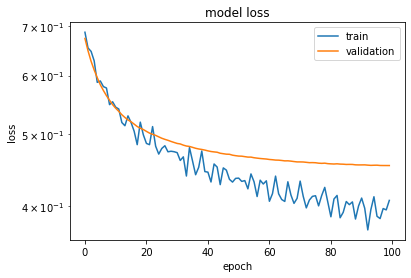

In [0]:
f1_smart_glv, acc_smart_glv = \
model_run(bs=32, ep=100, lr=.0001, typ='embed',
          xt=xtrain_smart_glv, yt=ytrain_smart,
          xv=xvalid_smart_glv, yv=yvalid_smart,
          embd=[length_long_sentence_smart_glv,
                vocab_length_smart_glv,
                100, embedMat_smart_glv])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 16,417
Trainable params: 16,417
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.6705 - acc: 0.6120 - val_loss: 0.6319 - val_acc: 0.6947
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6018 - acc: 0.7240 - val_loss: 0.5684 - val_acc: 0.7643
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5530 - acc:

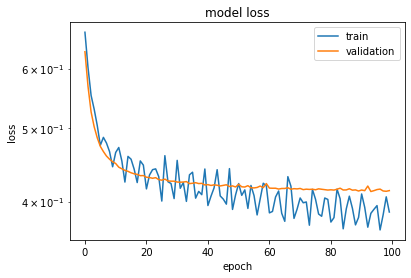

In [0]:
f1_orig_elmo, acc_orig_elmo = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_orig_elmo, yt=ytrain_orig,
          xv=xvalid_orig_elmo, yv=yvalid_orig)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 16,417
Trainable params: 16,417
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6726 - acc: 0.5807 - val_loss: 0.6558 - val_acc: 0.5739
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6465 - acc: 0.5664 - val_loss: 0.6291 - val_acc: 0.5824
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6206 - acc:

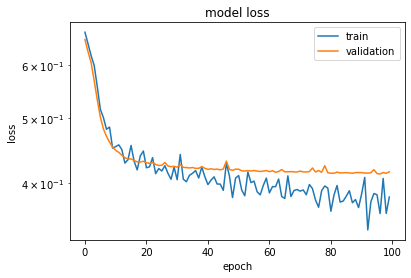

In [0]:
f1_basic_elmo, acc_basic_elmo = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_basic_elmo, yt=ytrain_basic,
          xv=xvalid_basic_elmo, yv=yvalid_basic)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 16,417
Trainable params: 16,417
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.6767 - acc: 0.5736 - val_loss: 0.6456 - val_acc: 0.6428
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6253 - acc: 0.6921 - val_loss: 0.6047 - val_acc: 0.6980
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5901 - acc:

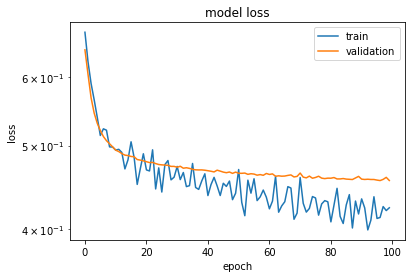

In [0]:
f1_portstem_elmo, acc_portstem_elmo = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_portstem_elmo, yt=ytrain_portstem,
          xv=xvalid_portstem_elmo, yv=yvalid_portstem)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 16,417
Trainable params: 16,417
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6394 - acc: 0.6237 - val_loss: 0.6063 - val_acc: 0.6947
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5676 - acc: 0.7246 - val_loss: 0.5418 - val_acc: 0.7663
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5450 - acc:

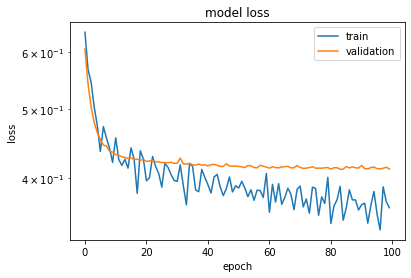

In [0]:
f1_smart_elmo, acc_smart_elmo = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_smart_elmo, yt=ytrain_smart,
          xv=xvalid_smart_elmo, yv=yvalid_smart)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6882 - acc: 0.5983 - val_loss: 0.6839 - val_acc: 0.6743
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6789 - acc: 0.7051 - val_loss: 0.6754 - val_acc: 0.7354
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6709 - acc: 0

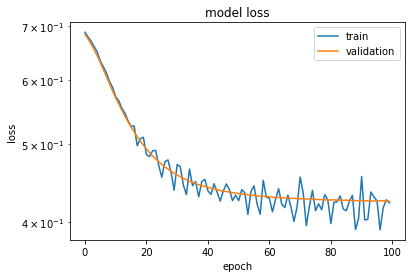

In [0]:
f1_orig_used, acc_orig_used = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_orig_used, yt=ytrain_orig,
          xv=xvalid_orig_used, yv=yvalid_orig)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.6904 - acc: 0.5423 - val_loss: 0.6861 - val_acc: 0.5995
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6798 - acc: 0.6842 - val_loss: 0.6758 - val_acc: 0.6953
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6702 - acc: 0

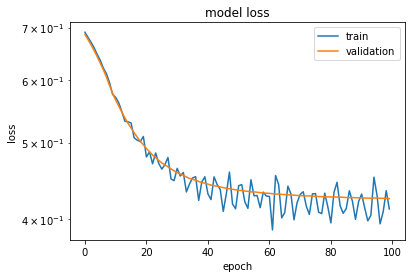

In [0]:
f1_basic_used, acc_basic_used = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_basic_used, yt=ytrain_basic,
          xv=xvalid_basic_used, yv=yvalid_basic)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6843 - acc: 0.6126 - val_loss: 0.6805 - val_acc: 0.6487
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6760 - acc: 0.6829 - val_loss: 0.6716 - val_acc: 0.6934
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6691 - acc: 0

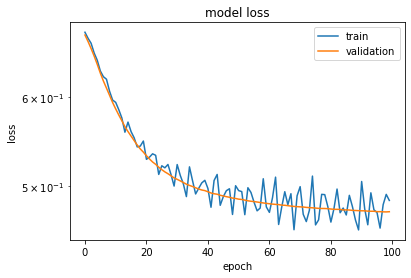

In [0]:
f1_portstem_used, acc_portstem_used = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_portstem_used, yt=ytrain_portstem,
          xv=xvalid_portstem_used, yv=yvalid_portstem)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6956 - acc: 0.4707 - val_loss: 0.6912 - val_acc: 0.5542
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6853 - acc: 0.6654 - val_loss: 0.6821 - val_acc: 0.6710
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6785 - acc: 0

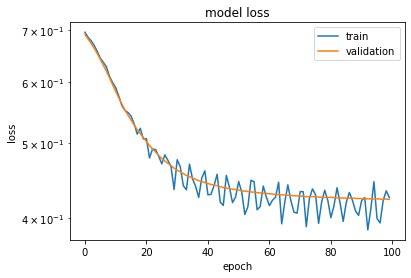

In [0]:
f1_smart_used, acc_smart_used = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_smart_used, yt=ytrain_smart,
          xv=xvalid_smart_used, yv=yvalid_smart)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6912 - acc: 0.5286 - val_loss: 0.6881 - val_acc: 0.5581
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6838 - acc: 0.6094 - val_loss: 0.6802 - val_acc: 0.6881
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6756 - acc: 0

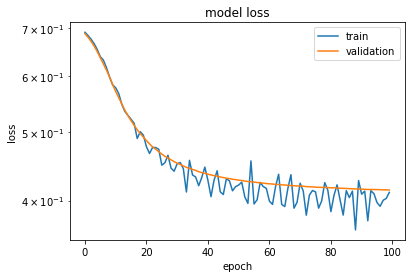

In [0]:
f1_orig_uset, acc_orig_uset = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_orig_uset, yt=ytrain_orig,
          xv=xvalid_orig_uset, yv=yvalid_orig)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6899 - acc: 0.5684 - val_loss: 0.6854 - val_acc: 0.6441
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6801 - acc: 0.7018 - val_loss: 0.6750 - val_acc: 0.7308
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6679 - acc: 0

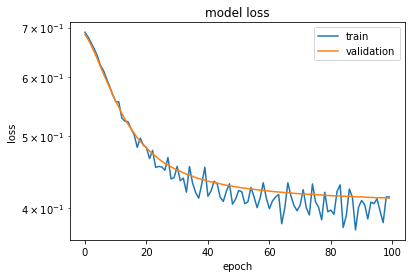

In [0]:
f1_basic_uset, acc_basic_uset = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_basic_uset, yt=ytrain_basic,
          xv=xvalid_basic_uset, yv=yvalid_basic)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6874 - acc: 0.5840 - val_loss: 0.6826 - val_acc: 0.5752
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6822 - acc: 0.5762 - val_loss: 0.6721 - val_acc: 0.6074
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6685 - acc: 0

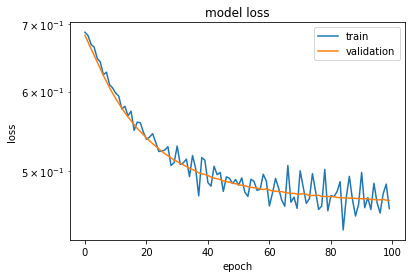

In [0]:
f1_portstem_uset, acc_portstem_uset = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_portstem_uset, yt=ytrain_portstem,
          xv=xvalid_portstem_uset, yv=yvalid_portstem)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.6917 - acc: 0.5371 - val_loss: 0.6863 - val_acc: 0.6067
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6825 - acc: 0.6289 - val_loss: 0.6764 - val_acc: 0.6940
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6711 - acc: 0

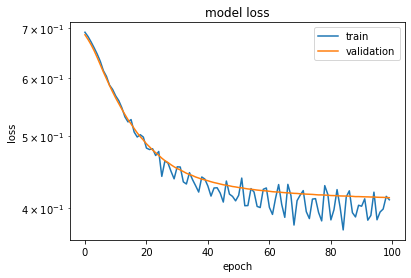

In [0]:
f1_smart_uset, acc_smart_uset = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_smart_uset, yt=ytrain_smart,
          xv=xvalid_smart_uset, yv=yvalid_smart)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                12304     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.6520 - acc: 0.6478 - val_loss: 0.6221 - val_acc: 0.7026
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5946 - acc: 0.7240 - val_loss: 0.5725 - val_acc: 0.7577
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5594 - acc:

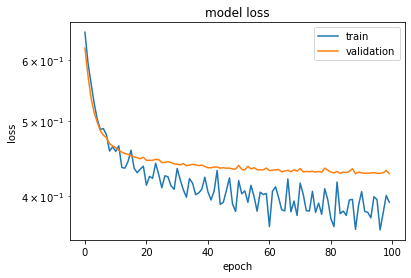

In [0]:
f1_orig_bert, acc_orig_bert = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_orig_bert, yt=ytrain_orig,
          xv=xvalid_orig_bert, yv=yvalid_orig)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                12304     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.6665 - acc: 0.5983 - val_loss: 0.6163 - val_acc: 0.7058
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5915 - acc: 0.7259 - val_loss: 0.5637 - val_acc: 0.7525
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5639 - acc:

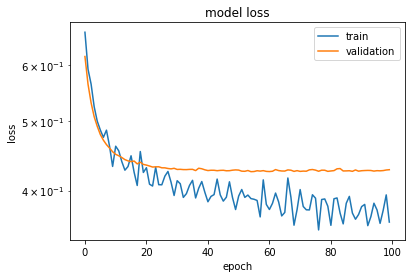

In [0]:
f1_basic_bert, acc_basic_bert = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_basic_bert, yt=ytrain_basic,
          xv=xvalid_basic_bert, yv=yvalid_basic)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                12304     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.6481 - acc: 0.6243 - val_loss: 0.6268 - val_acc: 0.6737
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6161 - acc: 0.6960 - val_loss: 0.5960 - val_acc: 0.7177
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5965 - acc:

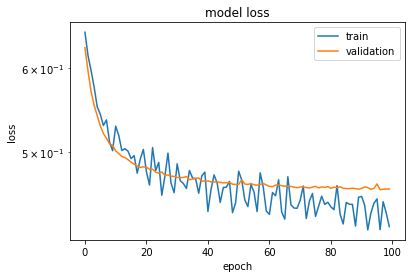

In [0]:
f1_portstem_bert, acc_portstem_bert = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_portstem_bert, yt=ytrain_portstem,
          xv=xvalid_portstem_bert, yv=yvalid_portstem)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                12304     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________
Train on 48 steps, validate on 1 steps
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.6758 - acc: 0.5632 - val_loss: 0.6535 - val_acc: 0.6362
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6132 - acc: 0.7012 - val_loss: 0.6013 - val_acc: 0.7275
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5857 - acc:

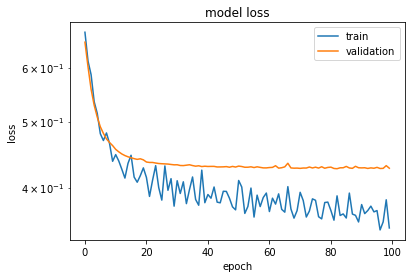

In [0]:
f1_smart_bert, acc_smart_bert = \
model_run(bs=32, ep=100, lr=.0001, typ='dense',
          xt=xtrain_smart_bert, yt=ytrain_smart,
          xv=xvalid_smart_bert, yv=yvalid_smart)

## Performance summary

In [0]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

print('Preprocessing: Original, Model: Self Embed')
print("Accuracy: " + "{:.2%}".format(acc_orig_self))
print("f1_score: " + "{:.3}".format(f1_orig_self))

print('\nPreprocessing: Basic, Model: Self Embed')      
print("Accuracy: " + "{:.2%}".format(acc_basic_self))
print("f1_score: " + "{:.3}".format(f1_basic_self))

print('\nPreprocessing: PortStem, Model: Self Embed')                       
print("Accuracy: " + "{:.2%}".format(acc_portstem_self))
print("f1_score: " + "{:.3}".format(f1_portstem_self))

print('\nPreprocessing: Smart, Model: Self Embed')                            
print("Accuracy: " + "{:.2%}".format(acc_smart_self))
print("f1_score: " + "{:.3}".format(f1_smart_self))


print('\n\nPreprocessing: Original, Model: GloVe')
print("Accuracy: " + "{:.2%}".format(acc_orig_glv))
print("f1_score: " + "{:.3}".format(f1_orig_glv))

print('\nPreprocessing: Basic, Model: GloVe')      
print("Accuracy: " + "{:.2%}".format(acc_basic_glv))
print("f1_score: " + "{:.3}".format(f1_basic_glv))

print('\nPreprocessing: PortStem, Model: GloVe')                       
print("Accuracy: " + "{:.2%}".format(acc_portstem_glv))
print("f1_score: " + "{:.3}".format(f1_portstem_glv))

print('\nPreprocessing: Smart, Model: GloVe')                            
print("Accuracy: " + "{:.2%}".format(acc_smart_glv))
print("f1_score: " + "{:.3}".format(f1_smart_glv))


print('\n\nPreprocessing: Original, Model: ELMo')
print("Accuracy: " + "{:.2%}".format(acc_orig_elmo))
print("f1_score: " + "{:.3}".format(f1_orig_elmo))

print('\nPreprocessing: Basic, Model: ELMo')      
print("Accuracy: " + "{:.2%}".format(acc_basic_elmo))
print("f1_score: " + "{:.3}".format(f1_basic_elmo))

print('\nPreprocessing: PortStem, Model: ELMo')                       
print("Accuracy: " + "{:.2%}".format(acc_portstem_elmo))
print("f1_score: " + "{:.3}".format(f1_portstem_elmo))

print('\nPreprocessing: Smart, Model: ELMo')                            
print("Accuracy: " + "{:.2%}".format(acc_smart_elmo))
print("f1_score: " + "{:.3}".format(f1_smart_elmo))


print('\n\nPreprocessing: Original, Model: USE (DAN)')
print("Accuracy: " + "{:.2%}".format(acc_orig_used))
print("f1_score: " + "{:.3}".format(f1_orig_used))

print('\nPreprocessing: Basic, Model: USE (DAN)')      
print("Accuracy: " + "{:.2%}".format(acc_basic_used))
print("f1_score: " + "{:.3}".format(f1_basic_used))

print('\nPreprocessing: PortStem, Model: USE (DAN)')                       
print("Accuracy: " + "{:.2%}".format(acc_portstem_used))
print("f1_score: " + "{:.3}".format(f1_portstem_used))

print('\nPreprocessing: Smart, Model: USE (DAN)')                            
print("Accuracy: " + "{:.2%}".format(acc_smart_used))
print("f1_score: " + "{:.3}".format(f1_smart_used))


print('\n\nPreprocessing: Original, Model: USE (Transformer)')
print("Accuracy: " + "{:.2%}".format(acc_orig_uset))
print("f1_score: " + "{:.3}".format(f1_orig_uset))

print('\nPreprocessing: Basic, Model: USE (Transformer)')      
print("Accuracy: " + "{:.2%}".format(acc_basic_uset))
print("f1_score: " + "{:.3}".format(f1_basic_uset))

print('\nPreprocessing: PortStem, Model: USE (Transformer)')                       
print("Accuracy: " + "{:.2%}".format(acc_portstem_uset))
print("f1_score: " + "{:.3}".format(f1_portstem_uset))

print('\nPreprocessing: Smart, Model: USE (Transformer)')                            
print("Accuracy: " + "{:.2%}".format(acc_smart_uset))
print("f1_score: " + "{:.3}".format(f1_smart_uset))


print('\n\nPreprocessing: Original, Model: BERT')
print("Accuracy: " + "{:.2%}".format(acc_orig_bert))
print("f1_score: " + "{:.3}".format(f1_orig_bert))

print('\nPreprocessing: Basic, Model: BERT')      
print("Accuracy: " + "{:.2%}".format(acc_basic_bert))
print("f1_score: " + "{:.3}".format(f1_basic_bert))

print('\nPreprocessing: PortStem, Model: BERT')                       
print("Accuracy: " + "{:.2%}".format(acc_portstem_bert))
print("f1_score: " + "{:.3}".format(f1_portstem_bert))

print('\nPreprocessing: Smart, Model: BERT')                            
print("Accuracy: " + "{:.2%}".format(acc_smart_bert))
print("f1_score: " + "{:.3}".format(f1_smart_bert))

Preprocessing: Original, Model: Self Embed
Accuracy: 66.12%
f1_score: 0.49

Preprocessing: Basic, Model: Self Embed
Accuracy: 65.73%
f1_score: 0.41

Preprocessing: PortStem, Model: Self Embed
Accuracy: 65.40%
f1_score: 0.434

Preprocessing: Smart, Model: Self Embed
Accuracy: 64.54%
f1_score: 0.385


Preprocessing: Original, Model: GloVe
Accuracy: 80.37%
f1_score: 0.757

Preprocessing: Basic, Model: GloVe
Accuracy: 79.51%
f1_score: 0.747

Preprocessing: PortStem, Model: GloVe
Accuracy: 78.27%
f1_score: 0.733

Preprocessing: Smart, Model: GloVe
Accuracy: 80.43%
f1_score: 0.755


Preprocessing: Original, Model: ELMo
Accuracy: 81.81%
f1_score: 0.775

Preprocessing: Basic, Model: ELMo
Accuracy: 81.88%
f1_score: 0.784

Preprocessing: PortStem, Model: ELMo
Accuracy: 79.91%
f1_score: 0.758

Preprocessing: Smart, Model: ELMo
Accuracy: 81.75%
f1_score: 0.777


Preprocessing: Original, Model: USE (DAN)
Accuracy: 81.94%
f1_score: 0.783

Preprocessing: Basic, Model: USE (DAN)
Accuracy: 81.94%
f1_sc

In [0]:
print('None\tBasic\tPortStem\tSmart')
print('\nSELF')
print("{:.2%}".format(acc_orig_self),"{:.2%}".format(acc_basic_self),
      "{:.2%}".format(acc_portstem_self),"{:.2%}".format(acc_smart_self))
print('\nGLOVE')
print("{:.2%}".format(acc_orig_glv),"{:.2%}".format(acc_basic_glv),
      "{:.2%}".format(acc_portstem_glv),"{:.2%}".format(acc_smart_glv))
print('\nELMO')
print("{:.2%}".format(acc_orig_elmo),"{:.2%}".format(acc_basic_elmo),
      "{:.2%}".format(acc_portstem_elmo),"{:.2%}".format(acc_smart_elmo))
print('\nUSED')
print("{:.2%}".format(acc_orig_used),"{:.2%}".format(acc_basic_used),
      "{:.2%}".format(acc_portstem_used),"{:.2%}".format(acc_smart_used))
print('\nUSET')
print("{:.2%}".format(acc_orig_uset),"{:.2%}".format(acc_basic_uset),
      "{:.2%}".format(acc_portstem_uset),"{:.2%}".format(acc_smart_uset))
print('\nBERT')
print("{:.2%}".format(acc_orig_bert),"{:.2%}".format(acc_basic_bert),
      "{:.2%}".format(acc_portstem_bert),"{:.2%}".format(acc_smart_bert))

None	Basic	PortStem	Smart

SELF
66.12% 65.73% 65.40% 64.54%

GLOVE
80.37% 79.51% 78.27% 80.43%

ELMO
81.81% 81.88% 79.91% 81.75%

USED
81.94% 81.94% 79.05% 81.88%

USET
82.27% 82.21% 79.71% 81.75%

BERT
82.21% 82.86% 80.70% 82.27%


# Add Keyword Embeddings


## GLOVE Keywords

In [0]:
word_tokenizer_orig_glv_kw, padded_sentences_orig_glv_kw, \
vocab_length_orig_glv_kw, length_long_sentence_orig_glv_kw \
= gloveEmbed(keyword_orig)

embedMat_orig_glv_kw = getEmbedMatrix(word_tokenizer_orig_glv_kw,
                                      vocab_length_orig_glv_kw)
xtrain_orig_glv_kw, xvalid_orig_glv_kw, \
ytrain_orig_glv_kw, yvalid_orig_glv_kw = \
train_test_split(padded_sentences_orig_glv_kw, train_target,
                 random_state=42,
                 test_size=0.2)

There are 241 unique words in the corpus
The longest sentence contains 5 words


In [0]:
def get_model_bert_kwglv(shp1, shp2, vcb_sz2, dim2, wt2):
    
    inp1 = tf.keras.Input(shape=(shp1,), dtype=tf.float32)
    x1 = tf.keras.layers.Dense(8, activation='relu')(inp1)
    x1 = tf.keras.Model(inputs=inp1, outputs=x1)

    inp2 = tf.keras.Input(shape=(shp2,), dtype=tf.float32)
    x2 = tf.keras.layers.Embedding(vcb_sz2, dim2, weights=[wt2],
                            input_length=shp2,
                            trainable=False)(inp2)
    x2 = tf.keras.layers.Flatten()(x2)                     
    x2 = tf.keras.layers.Dense(8,activation='relu')(x2)
    x2 = tf.keras.Model(inputs=inp2, outputs=x2)
    
    out = tf.keras.layers.concatenate([x1.output, x2.output])
    out = tf.keras.layers.Dense(4, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)
    return tf.keras.Model(inputs=[x1.input, x2.input], outputs=[out])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 100)       24100       input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 500)          0           embedding[0][0]                  
____________________________________________________________________________________________

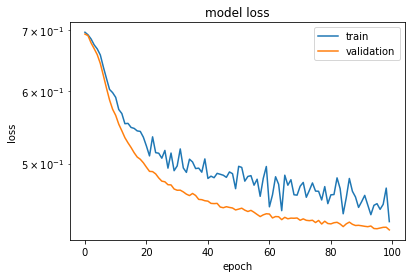

In [0]:
f1_orig_glv_kw, acc_orig_glv_kw = \
model_run(bs=32, ep=100, lr=.0001, typ='bertkw',
          xt=(xtrain_orig_bert, xtrain_orig_glv_kw), yt=ytrain_orig,
          xv=(xvalid_orig_bert, xvalid_orig_glv_kw), yv=yvalid_orig,
          embd=[length_long_sentence_orig_glv_kw,
                vocab_length_orig_glv_kw,
                100, embedMat_orig_glv_kw])

# Ensemble Runs


In [0]:
def get_model_used_bert_glv(shp1, shp2, shp3, vcb_sz3, dim3, wt3):
    inp1 = tf.keras.Input(shape=(shp1, ), dtype=tf.float32)
    x1 = tf.keras.layers.Dense(8, activation='relu',
                               kernel_regularizer=regularizers.l2(0.02))(inp1)
    x1 = tf.keras.Model(inputs=inp1, outputs=x1)

    inp2 = tf.keras.Input(shape=(shp2,), dtype=tf.float32)
    x2 = tf.keras.layers.Dense(8, activation='relu',
                               kernel_regularizer=regularizers.l2(0.02))(inp2)
    x2 = tf.keras.Model(inputs=inp2, outputs=x2)

    inp3 = tf.keras.Input(shape=(shp3,), dtype=tf.float32)
    x3 = tf.keras.layers.Embedding(vcb_sz3, dim3, weights=[wt3],
                            input_length=shp3,
                            trainable=False)(inp3)
    x3 = tf.keras.layers.Conv1D(filters=4, kernel_size=2,
                                activation='relu', strides=2)(x3)
    #x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.GlobalMaxPool1D()(x3)                     
    x3 = tf.keras.layers.Dense(8,activation='relu',
                               kernel_regularizer=regularizers.l1(0.02))(x3)
    x3 = tf.keras.Model(inputs=inp3, outputs=x3)

    out = tf.keras.layers.concatenate([x1.output, x2.output, x3.output])
    out = tf.keras.layers.Dense(4, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)
    return tf.keras.Model(inputs=[x1.input, x2.input, x3.input], outputs=[out])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 100)      2201800     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15, 4)        804         embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

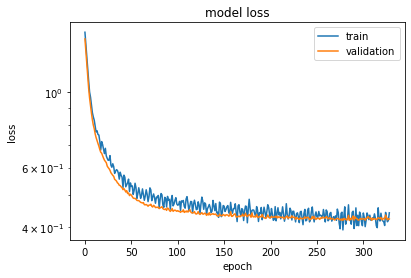

In [36]:
f1_orig_ubg, acc_orig_ubg = \
model_run(bs=16, ep=1000, lr=.0001, typ='ubg',
          xt=(xtrain_basic_uset, xtrain_basic_bert, xtrain_basic_glv),
          yt=ytrain_basic,
          xv=(xvalid_basic_uset, xvalid_basic_bert, xvalid_basic_glv),
          yv=yvalid_basic,
          embd=[length_long_sentence_basic_glv,
                vocab_length_basic_glv,
                100, embedMat_basic_glv])

In [40]:
print("{:.3}".format(f1_orig_ubg) + "\t{:.2%}".format(acc_orig_ubg))

0.799	84.11%
